In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Diabetes Prediction using Decision Tree and Random Forest

## Objective
Predict whether a patient has diabetes based on medical diagnostic measurements:
- Number of pregnancies
- Body mass index (BMI)
- Blood pressure
- Insulin level
- Age

## Key Characteristics
- Numerical predictors with medical relevance
- Binary classification (diabetic vs. non-diabetic)
- Focus on reducing false negatives
- Handling noisy data and class imbalances

## Evaluation Metrics
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

In [34]:
# Load and examine the data
df = pd.read_csv('diabetes.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Basic dataset info
print("\n=== DATASET OVERVIEW ===")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Class distribution
print("\nClass Distribution:")
print(df['Outcome'].value_counts(normalize=True))

Dataset Shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

=== DATASET OVERVIEW ===

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
Diabete

In [35]:
# Data preprocessing
def preprocess_data(df):
    # Create a copy
    df_clean = df.copy()
    
    # Handle zero values in medical measurements (likely to be missing/invalid data)
    zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for column in zero_columns:
        # Replace 0s with median of non-zero values
        median_value = df_clean[df_clean[column] != 0][column].median()
        df_clean[column] = df_clean[column].replace(0, median_value)
    
    return df_clean

# Preprocess the data
df_clean = preprocess_data(df)

# Split features and target
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Split the data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

Training set shape: (614, 8)
Testing set shape: (154, 8)

Class distribution in training set:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64


In [ ]:
# Decision Tree with hyperparameter tuning
def tune_decision_tree(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(
        dt, param_grid, cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
    
    return grid_search.best_estimator_

# Train Decision Tree
print("=== Training Decision Tree ===")
dt_model = tune_decision_tree(X_train_scaled, y_train)

=== Training Decision Tree ===
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.7628
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.7628


In [43]:
# Evaluate Decision Tree model
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)  # diagonal line
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    
    # Plot 3: Feature Importance
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=importance, ax=axes[2])
    axes[2].set_title(f'Feature Importance - {model_name}')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }



# Model Evaluation


=== Decision Tree Performance ===
Accuracy: 0.6818
Precision: 0.6190
Recall: 0.2407
F1-Score: 0.3467
ROC-AUC: 0.8066

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       100
           1       0.62      0.24      0.35        54

    accuracy                           0.68       154
   macro avg       0.66      0.58      0.57       154
weighted avg       0.67      0.68      0.63       154



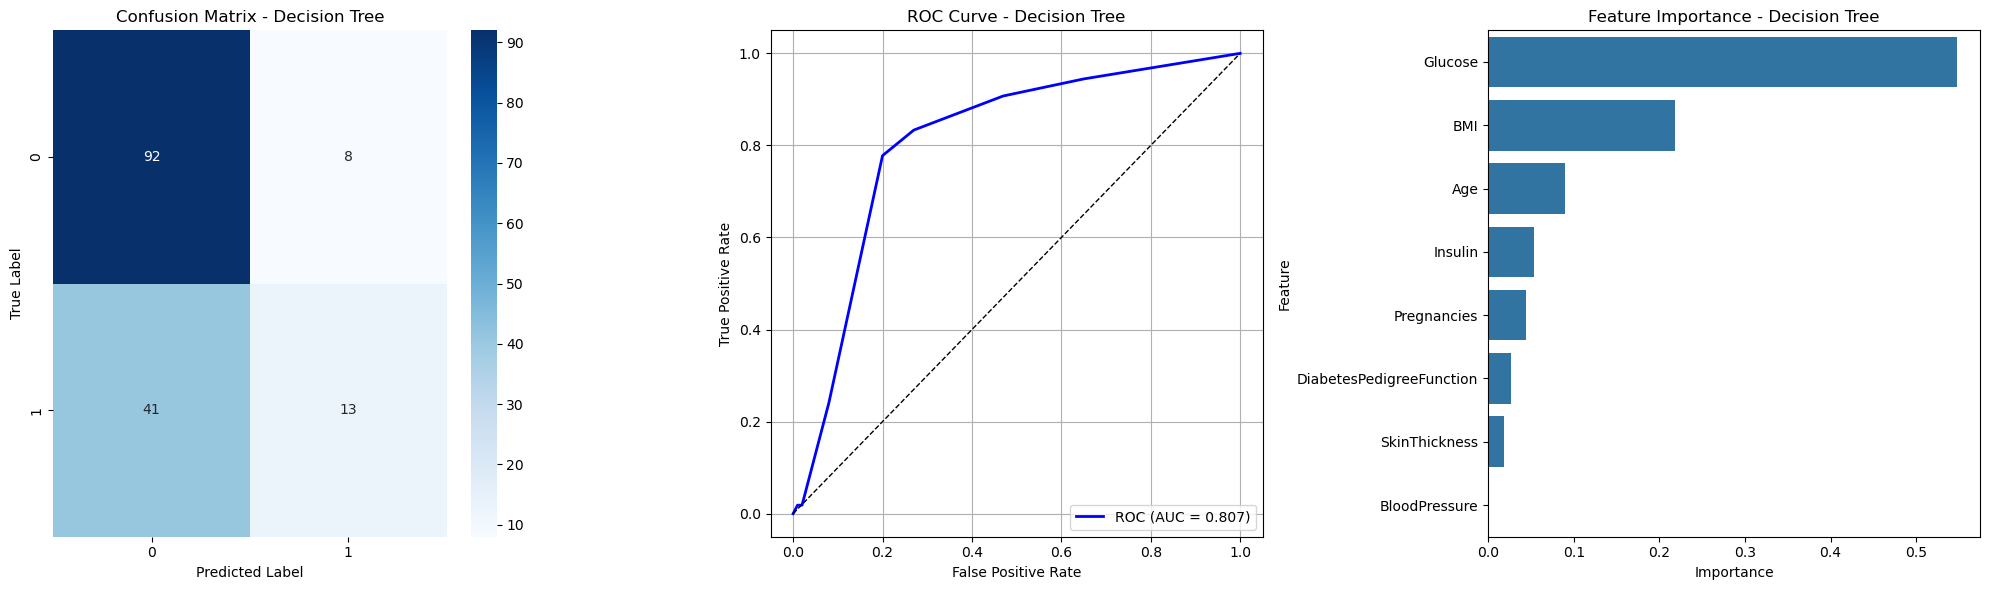

In [45]:
# Evaluate Decision Tree model
dt_results = evaluate_model(dt_model, X_test_scaled, y_test, "Decision Tree")

In [ ]:
# Random Forest with hyperparameter tuning
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf, param_grid, cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

    return grid_search.best_estimator_

# Train Random Forest
print("=== Training Random Forest ===")
rf_model = tune_random_forest(X_train_scaled, y_train)

=== Training Random Forest ===
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.8328
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.8328



=== Random Forest Performance ===
Accuracy: 0.7403
Precision: 0.6591
Recall: 0.5370
F1-Score: 0.5918
ROC-AUC: 0.8085

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       100
           1       0.66      0.54      0.59        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.73      0.74      0.73       154



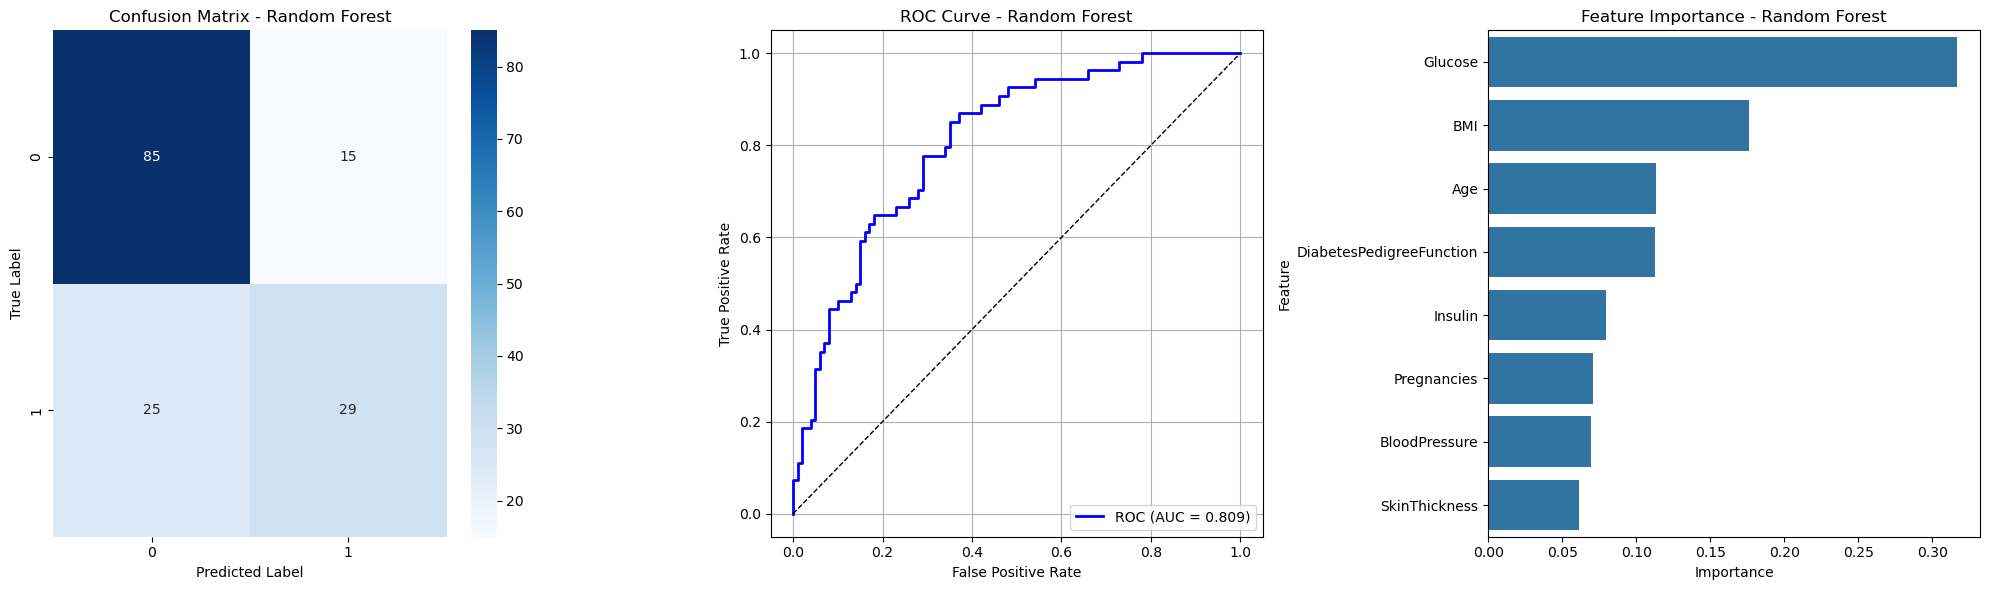

In [47]:
# Evaluate Random Forest model
rf_results = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

<Figure size 1000x600 with 0 Axes>

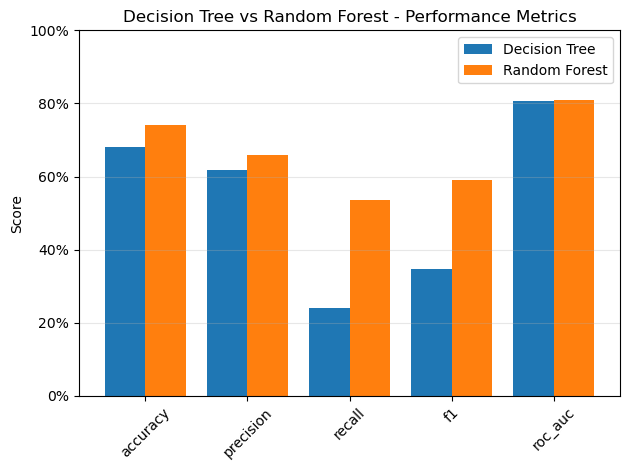

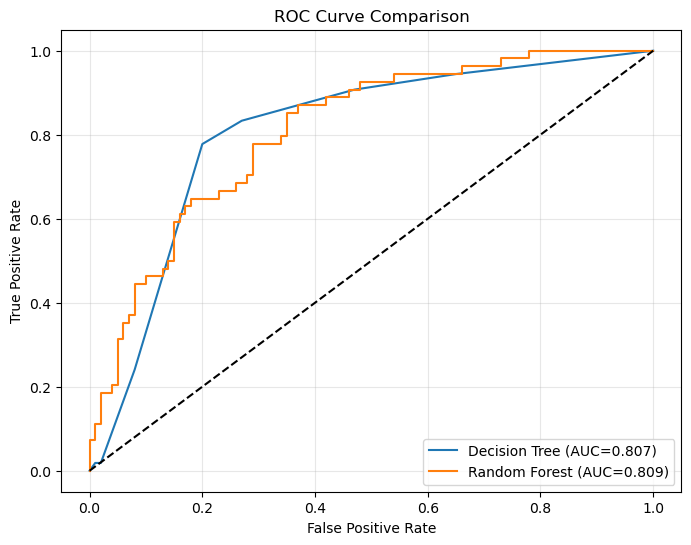

In [41]:
# Compare Decision Tree and Random Forest (metrics and ROC)
def compare_dt_rf(dt_results, rf_results, y_test):
    import matplotlib.ticker as mtick
    metrics = ['accuracy','precision','recall','f1','roc_auc']
    dt_scores = [dt_results[m] for m in metrics]
    rf_scores = [rf_results[m] for m in metrics]

    comp_df = pd.DataFrame({'Decision Tree': dt_scores, 'Random Forest': rf_scores}, index=metrics)
    
    # Bar chart comparison
    plt.figure(figsize=(10,6))
    comp_df.plot(kind='bar', width=0.8)
    plt.title('Decision Tree vs Random Forest - Performance Metrics')
    plt.ylim(0,1)
    plt.ylabel('Score')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ROC curve comparison
    plt.figure(figsize=(8,6))
    fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_results['probabilities'])
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['probabilities'])
    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_results["roc_auc"]:.3f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_results["roc_auc"]:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run comparison
compare_dt_rf(dt_results, rf_results, y_test)